In [1]:
import pandas as pd
import numpy as np
import os, random
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
import shutil
from PIL import Image
from keras import backend as K
from matplotlib import pyplot as plt
from matplotlib import colors
from pylab import cm
from skimage.io import imread
from skimage.transform import resize
    
from skimage import segmentation
from skimage.morphology import watershed
from skimage import measure
from skimage import morphology

# make graphics inline
%matplotlib inline

Using TensorFlow backend.


<h3>Move images into folders</h3>

In [17]:
#COPY training files to subfolders

# Create new maps for putting training data if not done already
if not os.path.exists('data/train_images_in_maps'):
    os.mkdir('data/train_images_in_maps')
if not os.path.exists('data/test_images_in_maps'):
    os.mkdir('data/test_images_in_maps')

#Import all possible classes
all_classes = pd.read_csv('label_map.txt', delim_whitespace=True, names=['Plankton', 'Index_number'])
all_classes.set_index(['Index_number'], inplace=True)

#Import train labels with class number for every image
labels_train_images = pd.read_csv('train_onelabel.csv')

#Add the matching class name to the train_labels
labels_train_images = pd.merge(labels_train_images, all_classes, how='outer', left_on='class', right_index=True, copy=True)

#Image name and label to dictionary (in order to move images)
label_dict = labels_train_images.set_index('image')['Plankton'].to_dict()

# Construct path names
# Move from:
train_data_path = 'data/train_images'
#test_data_path = 'data/test_images'
# Move to:
train_data_path_maps = 'data/train_images_in_maps'
#test_data_path_maps = 'data/test_images_in_maps'

#List of images
list_train_images = os.listdir(train_data_path)
list_test_images = os.listdir(test_data_path)

# Copy and move the files
for file in list_train_images:
    for key, value in label_dict.items():
        if file == key:
            path = os.path.join(train_data_path_maps, value)
            if not os.path.exists(path):
                os.makedirs(path)
            shutil.copy(os.path.join(train_data_path, file), path)
            
print('Finished with copying files to subfolders')

Finished with moving files to subfolders


<h3>Make a validation split</h3>

In [43]:
#Specify validation split
validation_split = 0.2

#Folder for validation split
validation_folder = 'data/validation_split'
if not os.path.exists(validation_folder):
    os.mkdir(validation_folder)

#Relist new folder structure
train_data_listing = os.listdir(train_data_path_maps)
#For loop for creating validation split
for folder in train_data_listing:
    subfolder = os.listdir(os.path.join(train_data_path_maps, folder))
    num_files_in_folder = len(subfolder)
    validation_copy = int(np.ceil((num_files_in_folder * validation_split)))
    for file in range(validation_copy):
        random_file = random.choice(subfolder)
        validation_path = os.path.join(validation_folder, folder)
        if not os.path.exists(validation_path):
            os.makedirs(validation_path)
        try:
            shutil.move(os.path.join(os.path.join(train_data_path_maps, folder), random_file), validation_path)
        except Exception:
            continue
print('Finished with creating validation split folder')

Finished with creating validation split folder


<h3>Preview KERAS augmentation</h3>

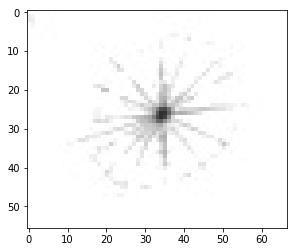

Image shape: (56, 67, 3)
New shape: (1, 56, 67, 3)
Check the new folder data\preview for what these lines of code did


In [41]:
#Load one image
img = load_img('data/train_images_in_maps/acantharia_protist_halo/48261.jpg')
plt.imshow(img, cmap=cm.gray)
plt.show()


# KERAS preprocessing
#Convert to Numpy array (xx, xx, xx)
x = img_to_array(img)
print('Image shape:', x.shape)

#Numpy array with shape (1, xx, xx, xx), anders werkt de datagenerator niet.
x = x.reshape((1,) + x.shape)

#print shape
print('New shape:', x2.shape)

# Set parameters
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

#Create test images for preview
if not os.path.exists('data/preview'):
    os.mkdir('data/preview')
i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='data/preview', save_prefix='acantharia_protist_halo', save_format='jpeg'):
    i += 1
    if i > 20:
        break
        
print('Check the new folder data\preview for what these lines of code did')



<h3>Feature extraction</h3>

In [ ]:
# Masks worden dus alleen gebruikt om features te berekenen, niet om de foto op te schonen.

# First we threshold the image by only taking values greater than the mean to reduce noise in the image
# to use later as a mask
im = imread('data/train_images/acantharia_protist_halo/48261.jpg', as_grey=True)
f = plt.figure(figsize=(12,3))
imthr = im.copy()
imthr = np.where(im > np.mean(im),0.,1.0)
sub1 = plt.subplot(1,4,1)
plt.imshow(im, cmap=cm.gray)
sub1.set_title("Original Image")

sub2 = plt.subplot(1,4,2)
plt.imshow(imthr, cmap=cm.gray_r)
sub2.set_title("Thresholded Image")

imdilated = morphology.dilation(imthr, np.ones((4,4)))
sub3 = plt.subplot(1, 4, 3)
plt.imshow(imdilated, cmap=cm.gray_r)
sub3.set_title("Dilated Image")

labels = measure.label(imdilated)
labels = imthr*labels
labels = labels.astype(int)
sub4 = plt.subplot(1, 4, 4)
sub4.set_title("Labeled Image")
plt.imshow(labels)

# Use mask to get image ratio


<h3>Keras Model construction</h3>

In [202]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

In [203]:
# Jaspers model (aangepast naar categorical)

train_data_path = 'data/train_images_in_maps'

#Parameters
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 25
batch_size = 32

#Set image dimensions
img_width = 95
img_height = 95

#Prepare data
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    

#Build model
model = Sequential()
#cyclic slice
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(LeakyReLU(alpha=1/3))
model.add(Conv2D(16, (3, 3)))
model.add(LeakyReLU(alpha=1/3))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

#Cyclic roll
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha=1/3))
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=1/3))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

#Cyclic roll
model.add(Conv2D(128, (3, 3)))
model.add(LeakyReLU(alpha=1/3))
model.add(Conv2D(128, (3, 3)))
model.add(LeakyReLU(alpha=1/3))
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha=1/3))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))   

#Cyclic roll
model.add(Conv2D(256, (3, 3)))
model.add(LeakyReLU(alpha=1/3))
#model.add(Conv2D(256, (3, 3)))
#model.add(LeakyReLU(alpha=1/3))
#model.add(Conv2D(128, (3, 3)))
#model.add(LeakyReLU(alpha=1/3))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

#Cyclic roll
model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(alpha=1/3))

#cyclic pooling(rms)
model.add(Dense(512))
model.add(LeakyReLU(alpha=1/3))
model.add(Dense(512))
model.add(LeakyReLU(alpha=1/3))
model.add(Dense(121))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
        rotation_range=360,
        rescale=1./1.6,
        shear_range=0.2,
        channel_shift_range=10,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

validation_folder = 'data/validation_split'
validation_generator = test_datagen.flow_from_directory(
    validation_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

model.save_weights('first_try.h5')
model.save('first_model.h5')

Found 19799 images belonging to 121 classes.
Found 4405 images belonging to 121 classes.
Epoch 1/25
62/62 [==============================] - 82s - loss: 4.4038 - acc: 0.0524 - val_loss: 4.7763 - val_acc: 0.0650
Epoch 2/25
62/62 [==============================] - 80s - loss: 4.1558 - acc: 0.1023 - val_loss: 4.7821 - val_acc: 0.0563
Epoch 3/25
62/62 [==============================] - 80s - loss: 4.0775 - acc: 0.1179 - val_loss: 4.7776 - val_acc: 0.0663
Epoch 4/25
62/62 [==============================] - 80s - loss: 3.9392 - acc: 0.1265 - val_loss: 4.7678 - val_acc: 0.0488
Epoch 5/25
62/62 [==============================] - 80s - loss: 3.8244 - acc: 0.1462 - val_loss: 4.7645 - val_acc: 0.0638
Epoch 6/25
62/62 [==============================] - 80s - loss: 3.6009 - acc: 0.1663 - val_loss: 4.7606 - val_acc: 0.0675
Epoch 7/25
62/62 [==============================] - 81s - loss: 3.4387 - acc: 0.1880 - val_loss: 4.7609 - val_acc: 0.0725
Epoch 8/25
62/62 [==============================] - 85s -

In [238]:
# CONSTRUCT MODEL (ander model)

#Parameters
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 250
batch_size = 32

#Set image dimensions
img_width = 95
img_height = 95

#Prepare data
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(121))
model.add(Activation('softmax'))

#opt = Adam(lr=0.0001, decay=1e-6) # initiate Adam optimizer

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [239]:
# PREPARE DATA

batch_size = 16

# this is the augmentation configuration we will use for training
def build(source=None):
        train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
        class_dictionary = data_generator.class_indices)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train_images_in_maps',  # this is the target directory
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')  

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation_split',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')



Found 19799 images belonging to 121 classes.
Found 4405 images belonging to 121 classes.


In [246]:
# TRAIN MODEL

#model.fit_generator(
 #       train_generator,
  #      steps_per_epoch=2000 // batch_size,
   #     epochs=10,
    #    validation_data=validation_generator,
     #   validation_steps=800 // batch_size)

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('third_try.h5') 
model.save('third_model.h5')

Epoch 1/250
125/125 [==============================] - 23s - loss: 4.3401 - acc: 0.0735 - val_loss: 4.0622 - val_acc: 0.0838
Epoch 2/250
125/125 [==============================] - 35s - loss: 4.2036 - acc: 0.0830 - val_loss: 4.0855 - val_acc: 0.1125
Epoch 3/250
125/125 [==============================] - 36s - loss: 4.1261 - acc: 0.0965 - val_loss: 3.9531 - val_acc: 0.1237
Epoch 4/250
125/125 [==============================] - 22s - loss: 3.9524 - acc: 0.1210 - val_loss: 3.7321 - val_acc: 0.1369
Epoch 5/250
125/125 [==============================] - 23s - loss: 3.8013 - acc: 0.1495 - val_loss: 3.5005 - val_acc: 0.2000
Epoch 6/250
125/125 [==============================] - 29s - loss: 3.7226 - acc: 0.1670 - val_loss: 3.3547 - val_acc: 0.2150
Epoch 7/250
125/125 [==============================] - 24s - loss: 3.6806 - acc: 0.1755 - val_loss: 3.3293 - val_acc: 0.2050
Epoch 8/250
125/125 [==============================] - 23s - loss: 3.5203 - acc: 0.2010 - val_loss: 3.4698 - val_acc: 0.2125


125/125 [==============================] - 22s - loss: 2.8266 - acc: 0.3135 - val_loss: 2.5632 - val_acc: 0.4188
Epoch 67/250
125/125 [==============================] - 22s - loss: 2.8329 - acc: 0.3365 - val_loss: 2.3610 - val_acc: 0.4250
Epoch 68/250
125/125 [==============================] - 22s - loss: 2.8091 - acc: 0.3336 - val_loss: 2.4048 - val_acc: 0.4138
Epoch 69/250
125/125 [==============================] - 22s - loss: 2.7912 - acc: 0.3340 - val_loss: 2.5276 - val_acc: 0.3975
Epoch 70/250
125/125 [==============================] - 22s - loss: 2.7264 - acc: 0.3385 - val_loss: 2.4464 - val_acc: 0.4225
Epoch 71/250
125/125 [==============================] - 22s - loss: 2.8110 - acc: 0.3340 - val_loss: 2.4175 - val_acc: 0.4150
Epoch 72/250
125/125 [==============================] - 22s - loss: 2.7974 - acc: 0.3275 - val_loss: 2.5060 - val_acc: 0.4175
Epoch 73/250
125/125 [==============================] - 22s - loss: 2.7805 - acc: 0.3370 - val_loss: 2.4119 - val_acc: 0.4347
Epoch

125/125 [==============================] - 22s - loss: 3.0780 - acc: 0.2820 - val_loss: 2.8042 - val_acc: 0.3325
Epoch 195/250
125/125 [==============================] - 23s - loss: 2.9396 - acc: 0.2945 - val_loss: 2.7338 - val_acc: 0.3438
Epoch 196/250
125/125 [==============================] - 22s - loss: 3.0278 - acc: 0.2980 - val_loss: 2.6032 - val_acc: 0.3387
Epoch 197/250
125/125 [==============================] - 22s - loss: 2.9403 - acc: 0.3008 - val_loss: 2.6083 - val_acc: 0.3967
Epoch 198/250
125/125 [==============================] - 22s - loss: 3.0075 - acc: 0.2880 - val_loss: 2.6016 - val_acc: 0.3812
Epoch 199/250
125/125 [==============================] - 22s - loss: 2.9737 - acc: 0.3140 - val_loss: 2.6972 - val_acc: 0.3875
Epoch 200/250
125/125 [==============================] - 23s - loss: 3.0672 - acc: 0.2865 - val_loss: 2.9213 - val_acc: 0.3187
Epoch 201/250
125/125 [==============================] - 23s - loss: 3.1283 - acc: 0.2800 - val_loss: 2.4378 - val_acc: 0.405

<h3>Predict class of test images</h3>

In [247]:
# Model inladen
loaded_model = load_model('third_model.h5')
loaded_model.load_weights('third_try.h5')

In [409]:
from keras.preprocessing import image
from keras.models import load_model

# Predict class of test images

# Create empty dataframe with two columns
test_images_pred = 0
test_images_pred = pd.DataFrame(columns=['image','class'])
row_nr = 0

for im in range(len(list_test_images)):
    img = image.load_img(('data/test_images/'+list_test_images[im]), target_size=(img_width, img_height)) # load image
    x = image.img_to_array(img) # image to array
    x = np.expand_dims(x, axis=0) # array veranderen, anders werkt het niet
    pred = model.predict_classes(x, batch_size=16) # predict class
    im_pred = pd.DataFrame([list_test_images[im],str(pred)],index=['image','class']) 
    test_images_pred = test_images_pred.append(im_pred.T)
    row_nr += 1

1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s


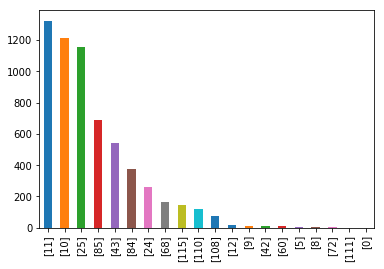

In [330]:
test_images_pred['class'].value_counts().plot(kind='bar')

In [250]:
test_images_pred['class'].value_counts()

[11]     1323
[10]     1210
[25]     1154
[85]      689
[43]      544
[84]      374
[24]      262
[68]      166
[115]     146
[110]     122
[108]      74
[12]       20
[9]        14
[42]       13
[60]       11
[5]         4
[8]         2
[72]        2
[111]       1
[0]         1
Name: class, dtype: int64

In [410]:
# Classes vanuit Keras in dictionary
class_dictionary = train_generator.class_indices
class_dictionary = {v: k for k, v in class_dictionary.items()}

# Aankoppelen bijbehorende class names van Keras model
test_images_pred['class'] = test_images_pred['class'].str.replace('[','')
test_images_pred['class'] = test_images_pred['class'].str.replace(']','')
test_images_pred['class'] = test_images_pred['class'].str.replace(' ','')
test_images_pred['class'] = pd.to_numeric(test_images_pred['class'])
test_images_pred['name'] = test_images_pred['class'].map(class_dictionary)
test_images_pred = test_images_pred.drop('class', 1)

# Aankoppelen classes label_map.txt
label_map = pd.read_csv('label_map.txt', delim_whitespace=True, header=None)
label_map = label_map[0]
label_map = label_map.to_dict()
label_map = {v: k for k, v in label_map.items()}
test_images_pred['class'] = test_images_pred['name'].map(label_map)

# Alleen benodigde kolommen behouden
test_images_pred = test_images_pred.drop('name', 1)
test_images_pred.head()

In [419]:
# Opslaan, let op versienummer als je oude voorspellingen wil behouden
test_images_pred.to_csv('test_images_prediction_v2.csv', index=False)